# CSSCVI Use Case - Mapping Into Unseen Condition with Attributes

**Note:** It is highly recommended to run the basic example before running this notebook to understand the aim fully.

In the basic example notebook, we had 2 attributes with on/off, yielding 4 different combinations. The model had seen all of these combinations in the training set and could map between one another.

Now, the model will only see 3 conditions in the training set: (0,0), (0,1), (1,0). The idea is that by learning the effects of (0,1) and (1,0) separately, the model will be able to map points into (1,1) 


## Imports

In [1]:
import torch, pyro, os, re, sys, warnings
import numpy as np
import pandas as pd
from wh.models.scvi_variants import SCVI, SCANVI, CSSCVI
from wh.models.basics import _broadcast_inputs, LinRegressor, _make_func, _make_fc
from wh.scripts.training import train_pyro, train_pyro_disjoint_param, get_device, train_lin_reg
from wh.scripts.metrics import get_reproduction_error, _get_subset, self_profile_reproduction, gen_profile_reproduction, get_normalized_profile, _get_rmse_n_to_1, _get_chamf_n_to_1, _get_sliced_wasserstein_n_to_1, _get_corr_n_to_1, _get_normalized_profile, knn_error, kmeans_nmi, kmeans_ari
from wh.data.real_data import construct_labels, distrib_dataset, MetadataConverter, AnndataConverter, _factors_to_col, make_lin_reg_data

from torchviz import make_dot
import torch.utils.data as utils
from itertools import combinations, product, permutations, chain
import inspect
import torch.optim as opt
from tqdm.notebook import tqdm

import umap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
import ot
from typing import Iterable, Literal
from scipy.stats import pearsonr
import anndata as ad
import scanpy as sc

import torch.nn as nn
import pyro.distributions as dist

import scib
from tqdm import trange
import pickle
from sklearn.preprocessing import OneHotEncoder


np.random.seed(42)
torch.manual_seed(42)
pyro.util.set_rng_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gamma_apr = np.round((1.-math.gamma(1+1.e-8))*1.e14 )*1.e-6

#device="cpu"

reducer = umap.UMAP(metric="correlation")

print(f"Device: {device}")

Device: cpu


## Dataset

We separate and keep the last attribute combination ( which is (1,1) )  for testing, the others are sent for training.

In [2]:
def _transform_labels(labels):
    return torch.hstack((labels[:,:2].argmax(-1).view(-1,1), labels[:,2:].argmax(-1).view(-1,1)))

def get_labels(labels):
    labs = _transform_labels(labels)
    df = pd.DataFrame(labs)
    df["comb"] = df.apply(lambda x : str(x[0]) + "," + str(x[1]), axis = 1)
    return torch.tensor(pd.get_dummies(df["comb"]).astype(int).to_numpy())



n = 500
lib_size=1000
batch_size=32
z_dim, w_dim, x_dim = 20, 10, 1000
theta = torch.tensor([10.0]*(x_dim*2))
z_mean, z_std = 0, 1
a_10_mean, a_10_std, a_11_mean, a_11_std = 2, 1, 10, 1
a_20_mean, a_20_std, a_21_mean, a_21_std = -1, 1, 5, 1




# create mappers for random vector of 1000: z, zw1, zw2, zw1w2

z_to_p1 = _make_fc([int(z_dim), 128, 128, int(x_dim/4)]) 
zw1_to_p2 = _make_fc([int(z_dim + w_dim), 128, 128, int(x_dim/4)])
zw2_to_p3 = _make_fc([int(z_dim + w_dim), 128, 128, int(x_dim/4)])
zw1w2_to_p4 = _make_fc([int(z_dim + w_dim*2), 128, 128, int(x_dim/4)])
lat_to_x = _make_func(in_dims=x_dim, hidden_dims=[128]*2, out_dim=x_dim*2, last_config="reparam", dist_config="zinb")




# Generate dataset
## Common
z_s = torch.normal(z_mean, z_std, size=(n*4, z_dim))


## Specific
w_0_0 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_0_1 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)
w_1_0 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_1_1 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)

## Combine Ws
w_s = torch.concat((w_0_0, w_0_1, w_1_0, w_1_1))

## Combine into full latents
zw_s = torch.concat((z_s, w_s), dim=-1)



# Generate from latents
with torch.no_grad():
    ## Common
    p1 = z_to_p1(zw_s[:,:20])

    ## Common + w1
    p2 = zw1_to_p2(zw_s[:,:30])

    ## Common + w2
    p3 = zw2_to_p3(torch.concat((zw_s[:,:20], zw_s[:,30:]), dim=-1))

    ## Common + w1 + w2
    p4 = zw1w2_to_p4(zw_s)


# Concat mixed params
p_s = torch.concat((p1,p2,p3,p4), dim=-1)


# ZINB
gate_logits, mu = lat_to_x(p_s)
nb_logits = (lib_size * mu + 1e-3).log() - (theta + 1e-3).log()
x_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits, total_count=theta,
                                                       logits=nb_logits, validate_args=False)

data = x_dist.sample()
labels = torch.concat((torch.tensor([1,0,1,0]).repeat((n,1)), torch.tensor([1,0,0,1]).repeat((n,1)), torch.tensor([0,1,1,0]).repeat((n,1)), torch.tensor([0,1,0,1]).repeat((n,1))))



train_set = utils.TensorDataset(data[:3*n].double(), labels[:3*n].double(), labels[:3*n].double())
test_set = utils.TensorDataset(data[3*n:].double(), labels[3*n:].double(), labels[3*n:].double())

train_loader, test_loader = utils.DataLoader(train_set, num_workers=4, batch_size=batch_size, shuffle=True), utils.DataLoader(test_set, num_workers=4, batch_size=batch_size, shuffle=False)

## Dataset Visualization

UMAP visualizations of the generated dataset

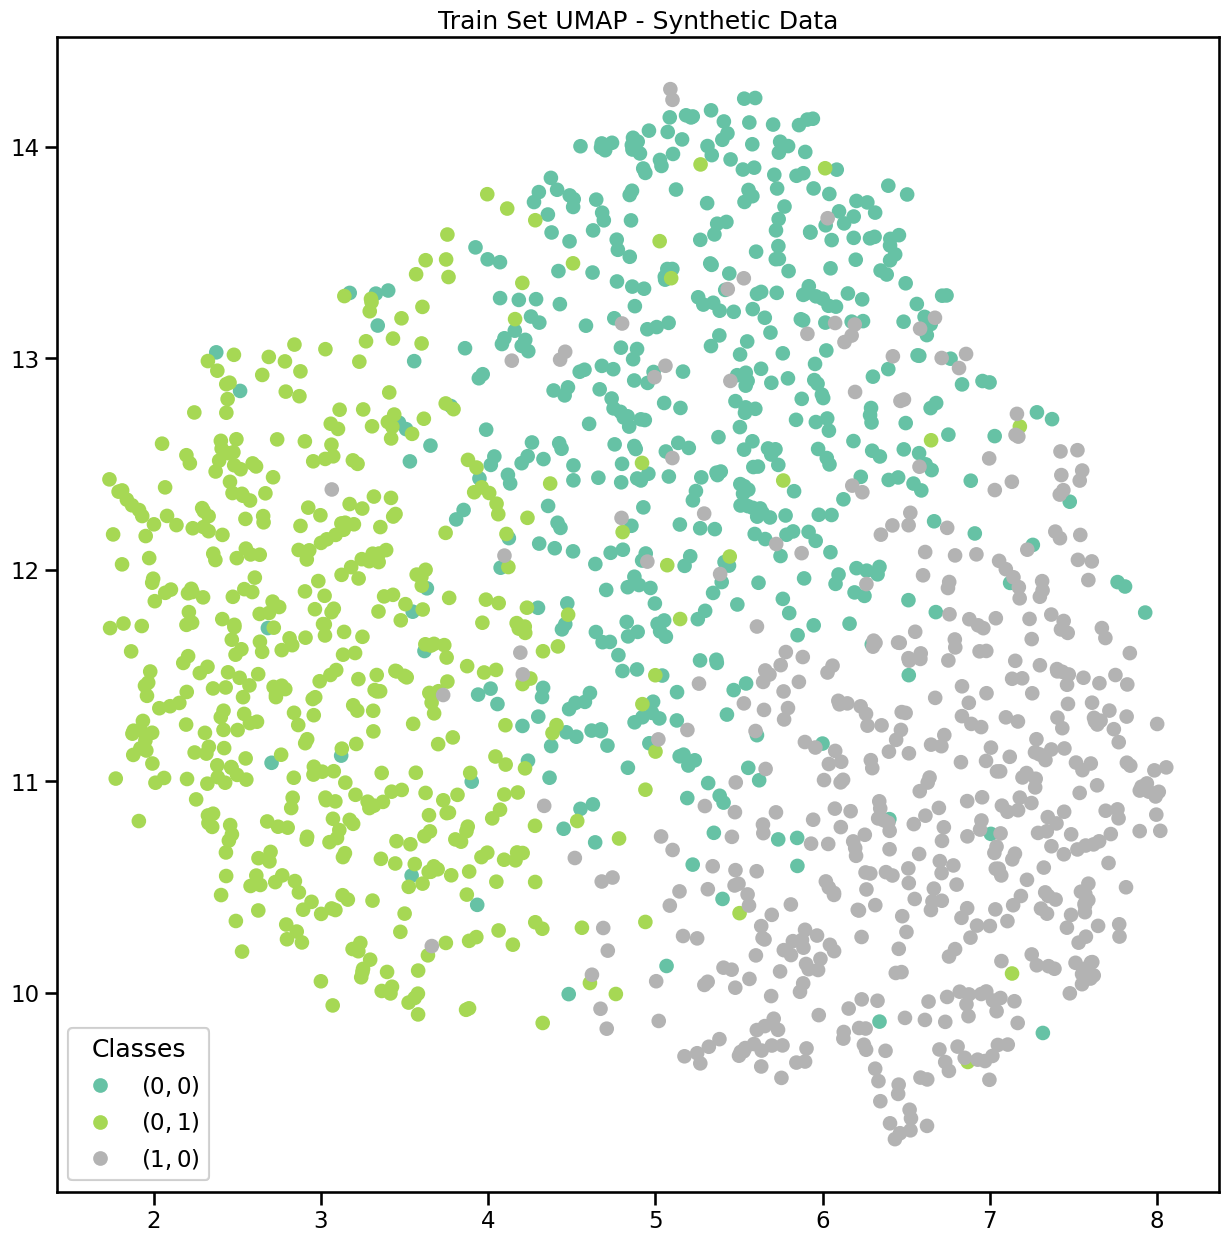

In [3]:
data_umap = reducer.fit_transform(train_set[:][0])

fig, ax = plt.subplots(1,1,figsize=(15,15))

scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=np.array(get_labels(train_set[:][1]).argmax(-1)), cmap="Set2", )


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$']

legend = ax.legend(*elems,
                    loc="lower left", title="Classes")

ax.add_artist(legend)
ax.set_title("Train Set UMAP - Synthetic Data")


plt.savefig("train_umap_synthetic.png", dpi=300, bbox_inches="tight")

plt.show()

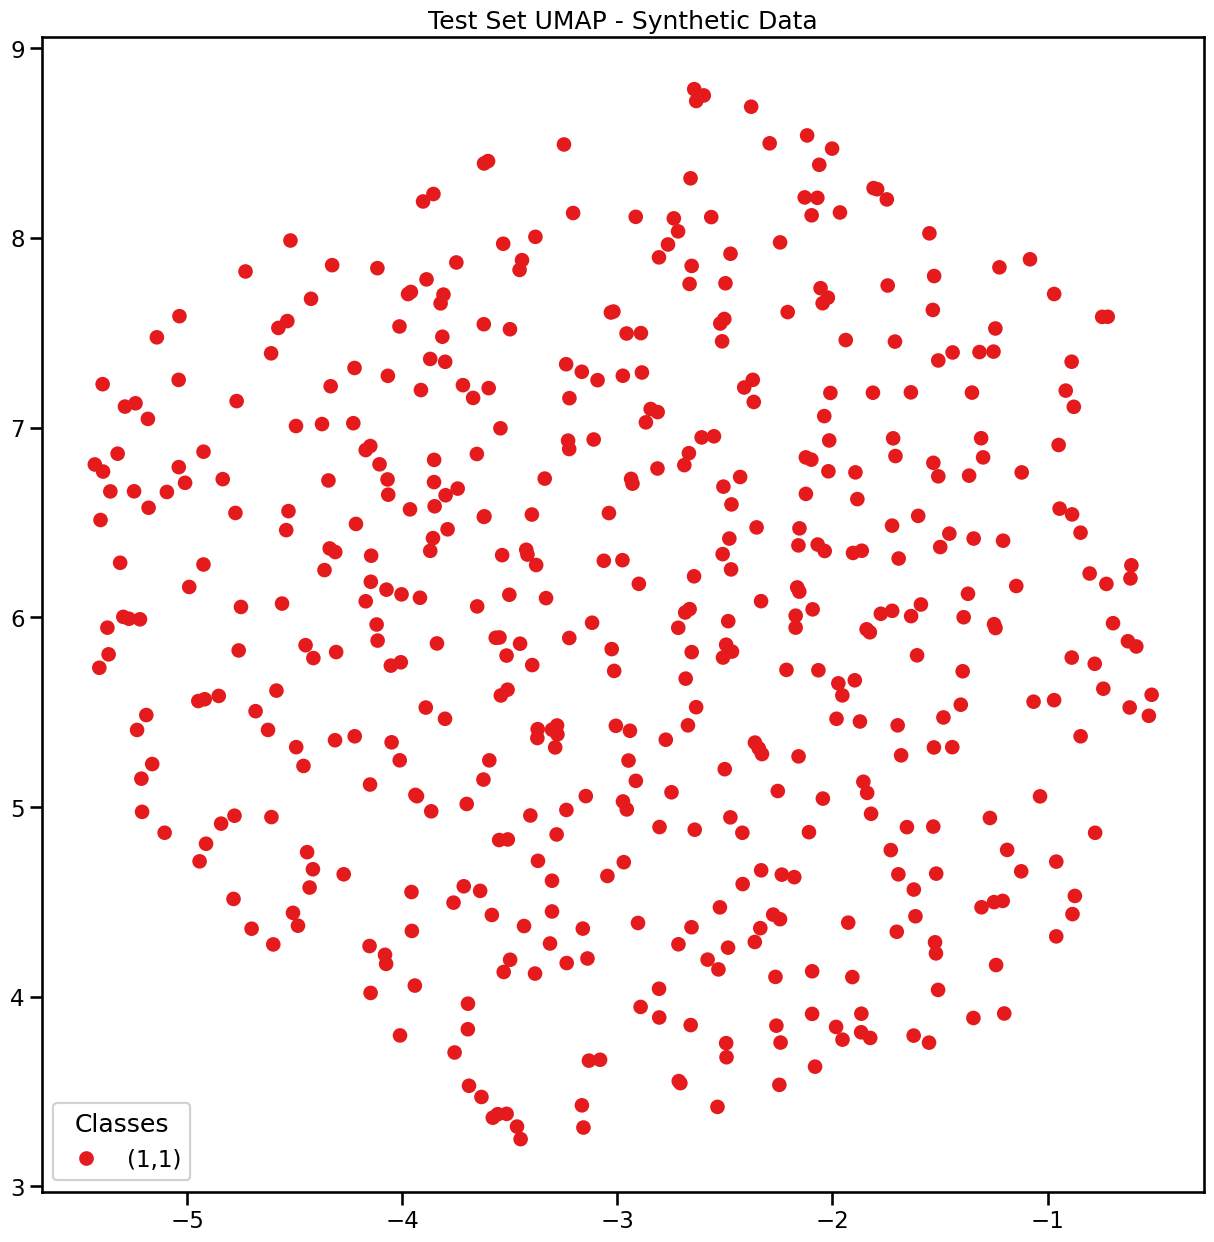

In [4]:
data_umap = reducer.fit_transform(test_set[:][0])

fig, ax = plt.subplots(1,1,figsize=(15,15))


scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=[0]*len(test_set), cmap="Set1")


elems = list(scatter.legend_elements())
elems[1] = ['(1,1)']

legend = ax.legend(*elems,
                    loc="lower left", title="Classes")

ax.add_artist(legend)

ax.set_title("Test Set UMAP - Synthetic Data")

plt.savefig("test_umap_synthetic.png", dpi=300, bbox_inches="tight")


plt.show()

## Model

This block lets you train the model from scratch or load pre-trained parameters for evaluation.

### Load

In [5]:
l_mean, l_scale = train_set[:][0].sum(-1).log().mean(), train_set[:][0].sum(-1).log().var()
len_attrs = [2,2]

pyro.clear_param_store()

csscvi = CSSCVI(num_genes=train_set[0][0].shape[0], num_labels=sum(len_attrs),
                l_loc=l_mean, l_scale=l_scale,
                alphas=[1, 1], w_loc=[0,3], w_scale=[0.1, 1], hidden_dim=256, num_layers=3, w_dim=10, latent_dim=20, len_attrs = len_attrs,
                scale_factor=1.0 / (batch_size * train_set[0][0].shape[0]), batch_correction=False).double()


csscvi.load("csscvi_synthetic_example_unseen")

### Train

In [ ]:
l_mean, l_scale = train_set[:][0].sum(-1).log().mean(), train_set[:][0].sum(-1).log().var()
len_attrs = [2,2]

pyro.clear_param_store()

csscvi = CSSCVI(num_genes=train_set[0][0].shape[0], num_labels=sum(len_attrs),
                l_loc=l_mean, l_scale=l_scale,
                alphas=[1, 1], w_loc=[0,3], w_scale=[0.1, 1], hidden_dim=256, num_layers=3, w_dim=10, latent_dim=20, len_attrs = len_attrs,
                scale_factor=1.0 / (batch_size * train_set[0][0].shape[0]), batch_correction=False).double()

csscvi, train_loss, test_loss, param_nonc_names, param_c_names = train_pyro_disjoint_param(csscvi, train_loader=train_loader, test_loader=test_loader, verbose=True, num_epochs=650, lr=1e-2, eps=1e-2, style="joint", warmup=0)

csscvi.save("csscvi_synthetic_example_unseen")

## Evaluation Metrics

Calculates metrics on aggregates (RMSE - Pearson Correlation) or point clouds (SWD - CD). Note that for the synthetic data, point cloud metrics are more indicative of performance.

Since the model did not see the Z (common) encodings for the kept out group, it is not expected to perform as well in reconstruction of the unseen group.

In [6]:
csscvi.eval()
predictive = pyro.infer.Predictive(csscvi.generate, num_samples=1)

for metric in ["rmse", "corr", "swd", "chamfer"]:
    preds_mean_error, pred_profiles, preds = get_reproduction_error(test_set, predictive, metric=metric, n_trials=10, verbose=True, use_cuda=False)
    print(f"{metric} : {np.round(preds_mean_error, 3)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.27it/s]


rmse : 5.882


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]


corr : -0.031


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.85it/s]


swd : 0.365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2435.01it/s]

chamfer : 0.646


## Mapping to Unseen Condition

This section closely resembles the mapping from the basic example notebook, but this time the mapped group was **NOT** directly included in the dataset.

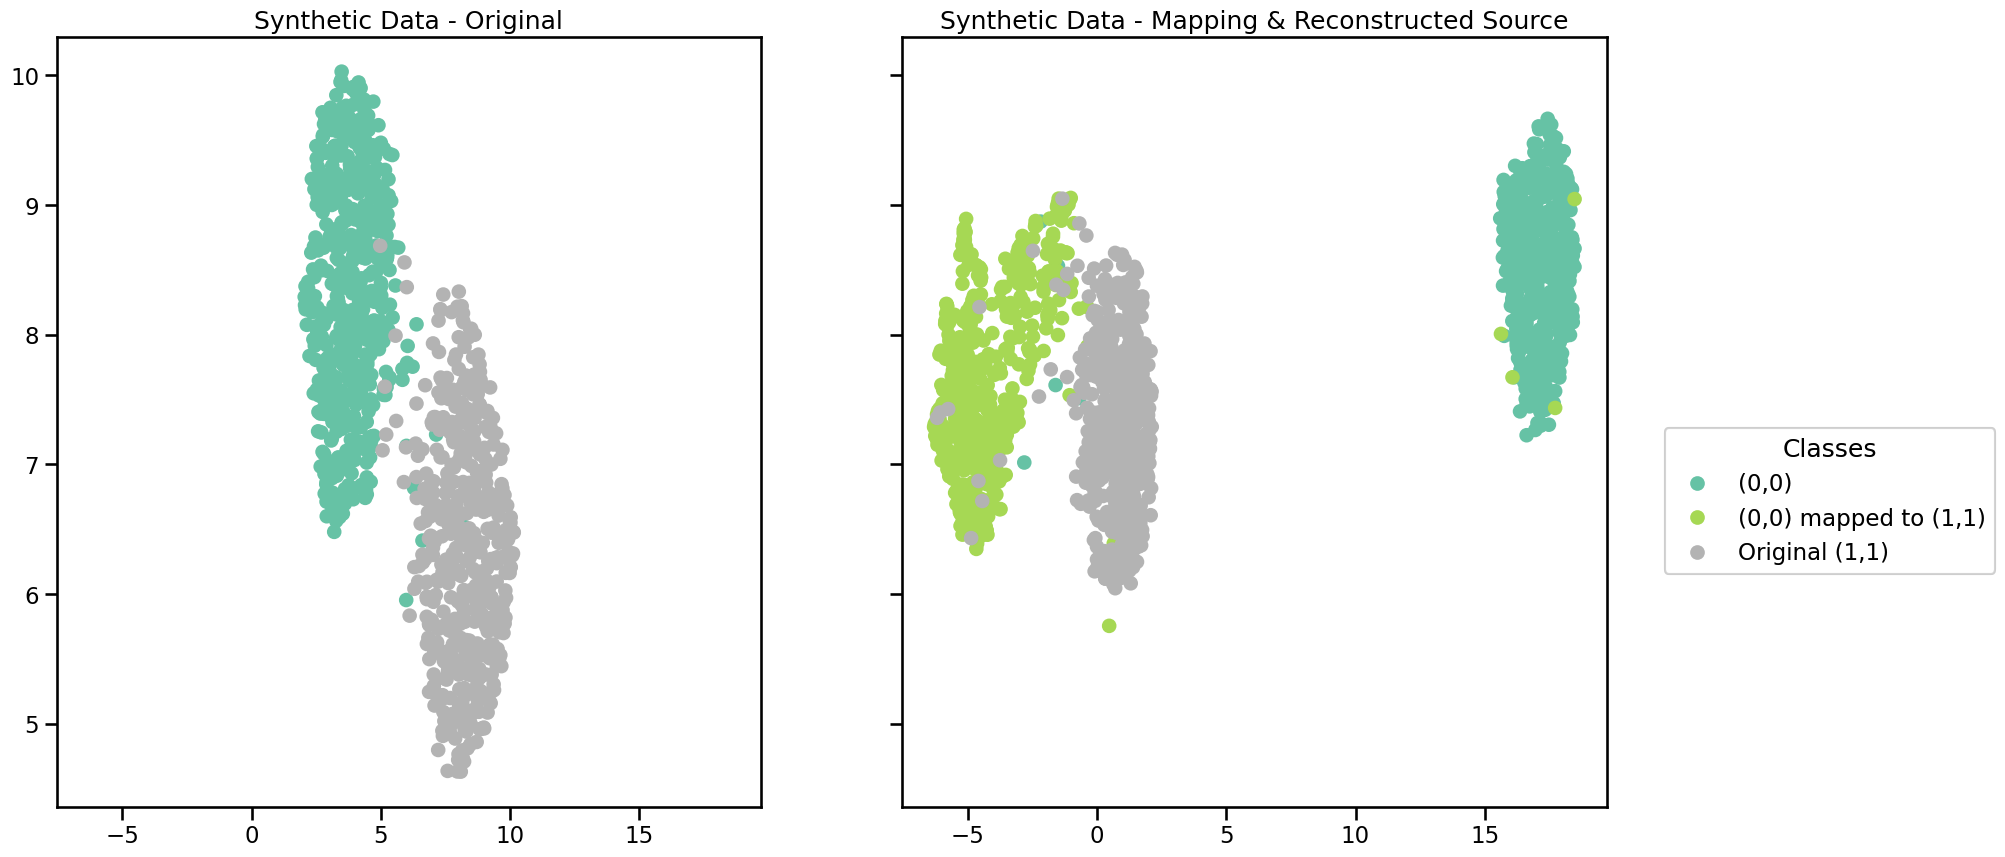

In [7]:
source_set, target_set = _get_subset(train_set, torch.tensor((1,0,1,0))), test_set
transformed = csscvi.generate(source_set[:][0], y_source=source_set[:][1], y_target=torch.tensor((0,1,0,1)).double().repeat(len(source_set[:][1]),1))
reconstructed =  predictive(source_set[:][0], source_set[:][1], source_set[:][1])["x"][0]

dat_orig = torch.concat((source_set[:][0], target_set[:][0]))
dat_recon = torch.concat((reconstructed, transformed, target_set[:][0]))

dat_orig_umap = reducer.fit_transform(dat_orig)
dat_recon_umap = reducer.fit_transform(dat_recon)

fig, ax = plt.subplots(1,2,figsize=(20,10), sharex=True, sharey=True)

ax[0].scatter(dat_orig_umap[:,0], dat_orig_umap[:,1], cmap="Set2", c= ([1]*len(source_set)) +([2]*len(target_set)))
scatter = ax[1].scatter(dat_recon_umap[:,0], dat_recon_umap[:,1], cmap="Set2", c= ([1]*len(source_set)) + ([2]*len(source_set)) + ([3]*len(target_set)))



elems = list(scatter.legend_elements())
elems[1] = [
 '(0,0)',
 '(0,0) mapped to (1,1)',
'Original (1,1)']

legend = fig.legend(*elems, bbox_to_anchor=(1.1,0.5), title="Classes")

fig.add_artist(legend)


ax[0].set_title("Synthetic Data - Original")
ax[1].set_title("Synthetic Data - Mapping & Reconstructed Source")



plt.savefig("mapping_with_synthetic_dat.png", dpi=300, bbox_inches="tight")



plt.show()